## Parking Lot Occupancy using

In [1]:
#imports
import os
import cv2
import torch
import random
import zipfile
import numpy as np
import torch.nn as nn
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
%matplotlib inline


In [2]:
# CSV file of both park_ext data
park_ext = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNRPark+EXT.csv"

# segmented images beloning to CNR_Park subset
cnr_park = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip"

# segmented images of for CNR_EXT subset
cnr_ext = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip"

df = pd.read_csv(park_ext)


<ipython-input-2-e642a892e47e>:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(park_ext)


In [4]:
# paths
zip_path = "/content/CNR-EXT-Patches-150x150.zip"
extract_path = "/content/CNR-EXT-Patches"

# Download and extract images
print("Downloading dataset...")
urlretrieve("https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip", zip_path)

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    zip_contents = zip_ref.namelist()

#print("Dataset extracted successfully!")
#for file in zip_contents:
    #print(file)

Extracting dataset...


In [5]:
# --- DATASET CLASS ---
class ParkingDataset(Dataset):
    def __init__(self, patch_dir, label_dir, transform=None, max_samples=2000):
        self.patch_dir = patch_dir
        self.label_dir = label_dir
        self.transform = transform
        self.patches = []
        self.labels = {}

        # Load label files
        for label_file in os.listdir(label_dir):
            if label_file.endswith(".txt"):
                label_path = os.path.join(label_dir, label_file)
                with open(label_path, "r") as file:
                    for line in file:
                        parts = line.strip().split(" ")
                        if len(parts) == 2:
                            img_relative_path, label = parts
                            full_img_path = os.path.join(patch_dir, "PATCHES", img_relative_path)
                            self.labels[full_img_path] = int(label)

        # Filter only labeled image paths
        for root, _, files in os.walk(patch_dir):
            for file in files:
                full_path = os.path.join(root, file)
                if full_path in self.labels:
                    self.patches.append(full_path)

        # Subset to speed up training
        if max_samples:
            self.patches = random.sample(self.patches, min(max_samples, len(self.patches)))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch_path = self.patches[idx]
        label = self.labels.get(patch_path, 0)

        patch = Image.open(patch_path).convert("RGB")

        if self.transform:
            patch = self.transform(patch)

        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # shape: [1]

        return patch, label



In [6]:
# --- TRANSFORMATIONS ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [7]:
# --- LOAD DATA ---
patch_dir = "/content/CNR-EXT-Patches"
label_dir = "/content/CNR-EXT-Patches/LABELS"

train_data = ParkingDataset(patch_dir, label_dir, transform=transform, max_samples=2000)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [8]:
# --- SETUP DEVICE & MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
from torchvision.models import resnet50
model = resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [9]:
# Replace the final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

In [10]:
# --- LOSS & OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
# --- LOSS HISTORY ---
train_losses = []
val_losses = []  # Optional: if you use a validation set

num_epochs = 5  # Change as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

Epoch 1/5 - Training Loss: 0.0543
Epoch 2/5 - Training Loss: 0.0309
Epoch 3/5 - Training Loss: 0.0236
Epoch 4/5 - Training Loss: 0.0209
Epoch 5/5 - Training Loss: 0.0216


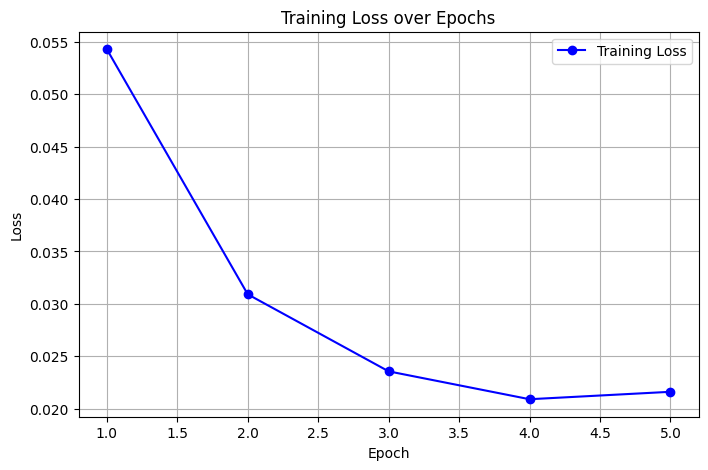

In [13]:
# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
from torch.utils.data import random_split

train_len = int(0.8 * len(train_data))
val_len = len(train_data) - train_len
train_subset, val_subset = random_split(train_data, [train_len, val_len])

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

In [15]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)

In [17]:
train_losses = []
train_accuracies = []

In [18]:
num_epochs = 5  # or more

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        preds = torch.sigmoid(outputs) >= 0.5  # binary threshold
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch 1/5 - Loss: 0.0313 - Accuracy: 0.9900
Epoch 2/5 - Loss: 0.0206 - Accuracy: 0.9925
Epoch 3/5 - Loss: 0.0168 - Accuracy: 0.9931
Epoch 4/5 - Loss: 0.0208 - Accuracy: 0.9931
Epoch 5/5 - Loss: 0.0129 - Accuracy: 0.9956


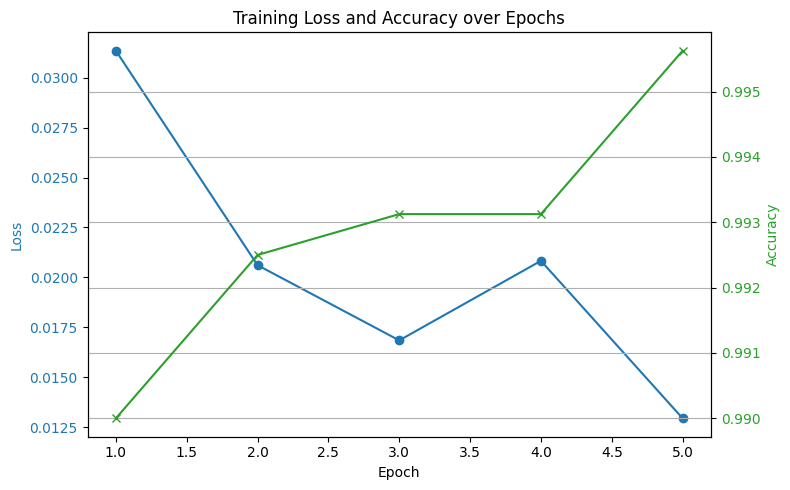

In [19]:
# Plot Loss and Accuracy on Dual Y-Axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Loss curve
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(train_losses)+1), train_losses, color=color, marker='o', label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Accuracy curve
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, len(train_accuracies)+1), train_accuracies, color=color, marker='x', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid
plt.title('Training Loss and Accuracy over Epochs')
fig.tight_layout()
plt.grid(True)
plt.show()
